In [10]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/university /fall 2024/markov model/markvod_models/generated_data`


Status `~/Documents/university /fall 2024/markov model/markvod_models/generated_data/Project.toml`
⌃ [e9467ef8] GLMakie v0.11.3
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [19]:
include("dimer_difussion.jl")
include("free_difusion.jl")
include("state_generator.jl")

get_state_transitions (generic function with 1 method)

In [32]:

using GLMakie
function animate_particles(p1, p2, filename="particle_animation.mp4")
    n_steps = size(p1, 2)
    
    # Create figure
    fig = Figure(size=(600, 600))
    ax = Axis(fig[1, 1], aspect=DataAspect())
    
    # Calculate axis limits
    all_x = vcat(p1[1,:], p2[1,:])
    all_y = vcat(p1[2,:], p2[2,:])
    
    x_range = maximum(all_x) - minimum(all_x)
    y_range = maximum(all_y) - minimum(all_y)
    
    limits!(ax, 0, 1, 0, 1)
    
    # Create initial points
    point1 = scatter!([p1[1,1]], [p1[2,1]], color=:blue, markersize=10)
    point2 = scatter!([p2[1,1]], [p2[2,1]], color=:red, markersize=10)
    
    # Create animation
    record(fig, filename, 1:n_steps; framerate=10) do frame
        # Update particle positions for current frame
        point1[1] = [p1[1,frame]]
        point1[2] = [p1[2,frame]]
        
        point2[1] = [p2[1,frame]]
        point2[2] = [p2[2,frame]]
    end
    
    return filename
end




function reverse_columns_preserve_size(arr)
    num_rows, num_cols = size(arr)
    result = zeros(eltype(arr), num_rows, num_cols)
    
    for col in 1:num_cols
        result[:, col] = arr[:, num_cols - col + 1]
    end
    
    return result
end


reverse_columns_preserve_size (generic function with 1 method)

In [36]:

k12 = 0.5
k21 = 0.15 
states, steps = simulate_states(k12, k21, 6)
transitions = get_state_transitions(states)

6-element Vector{Any}:
 (27, 1, 2)
 (92, 2, 1)
 (144, 1, 2)
 (238, 2, 1)
 (284, 1, 2)
 (341, 2, 1)

In [41]:
# 19 - 84 state 2
steps = transitions[2][1]-transitions[1][1]
p1_path_2, p2_path_2 = constrained_diffusion(steps = steps, animate= true,filename = "19-84.mp4",r = 0.01,box = 1.0,dt = 0.016)


Animation saved as '19-84.mp4'


([0.7970914348407886 0.7862469018435106 … 0.704050917220652 0.6870017849883676; 0.7488147388681613 0.7664423381571241 … 0.9305018338843262 0.9232812276929673], [0.8068480268895666 0.7837875738301558 … 0.7058271825576384 0.6771199847018912; 0.7466218157975267 0.7761352069647955 … 0.940342813584164 0.9217482491875104])

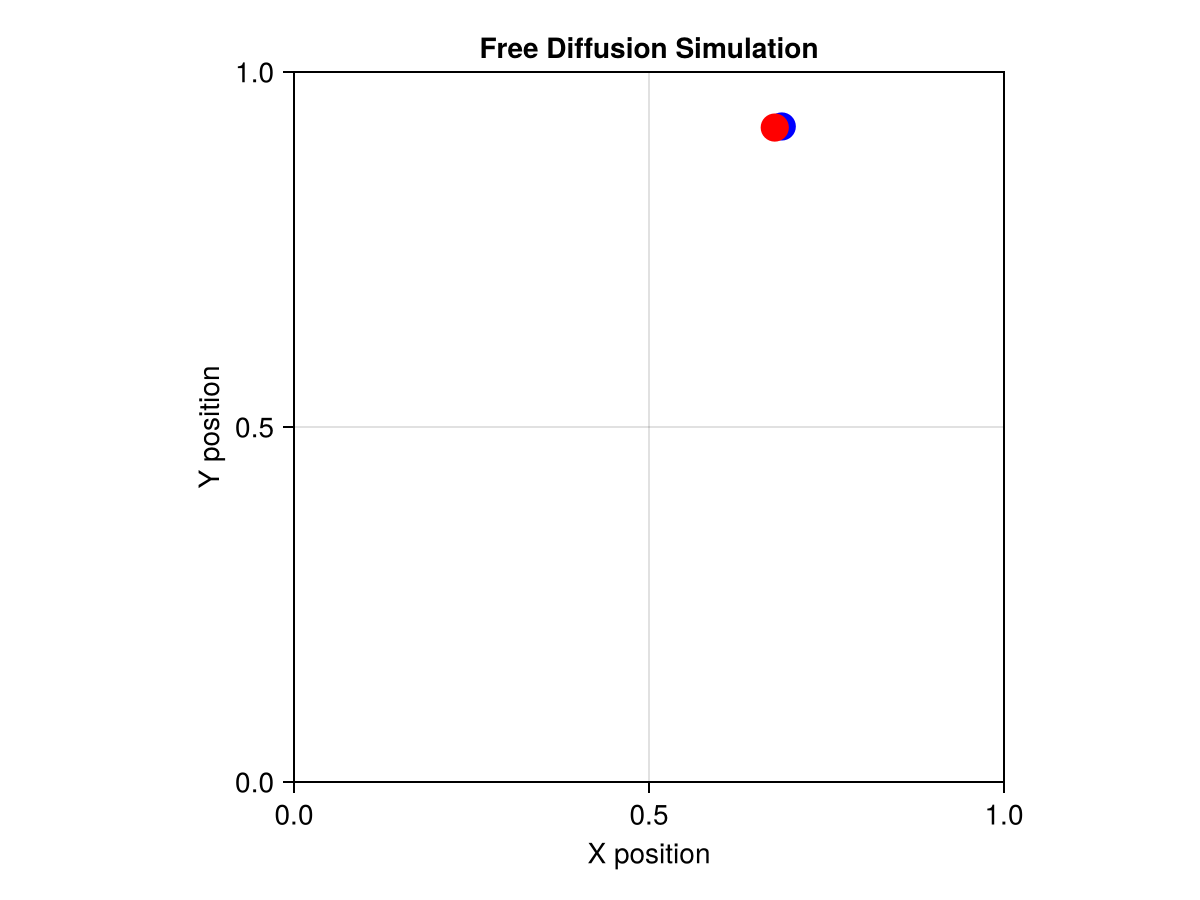

Animation saved as '85-102.mp4'


([0.6870017849883676 0.7040975928379286 … 0.7202157888031807 0.7173966102842223; 0.9232812276929673 0.9366498178239938 … 0.8601704052102732 0.8394861667794588], [0.6771199847018912 0.6767650262541136 … 0.7097652087495487 0.7136981813355365; 0.9217482491875104 0.9046376272900601 … 0.8602912367216645 0.850925576370565])

In [45]:
steps =round(Int, abs((transitions[3][1]/2) -transitions[2][1]))
positions = ([p1_path_2[1,end],p1_path_2[2,end]],[p2_path_2[1,end],p2_path_2[2,end]])
p1_path_3, p2_path_3 = simulate_diffusion(initial_positions=positions,steps = steps, animate= true,filename = "85-102.mp4",box = 1.0,dt = 0.016)

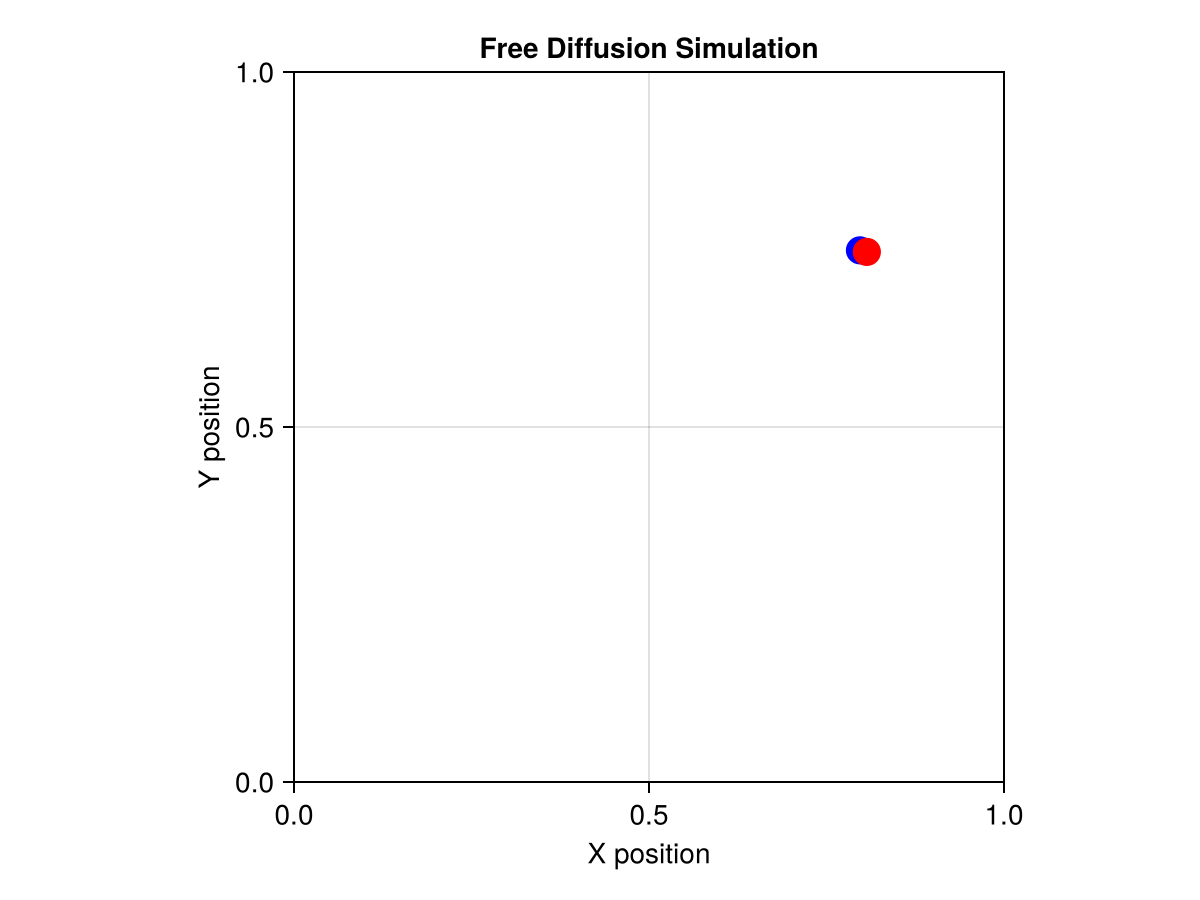

Animation saved as '0-18.mp4'


2×27 Matrix{Float64}:
 0.851592  0.852859  0.850239  0.854002  …  0.836264  0.807873  0.806848
 0.725619  0.71832   0.701158  0.704435     0.766102  0.763737  0.746622

In [46]:
# 0 - 18  state 1 
steps = transitions[1][1]
positions = ([p1_path_2[1,1],p1_path_2[2,1]],[p2_path_2[1,1],p2_path_2[2,1]])
p1_path_1, p2_path_1 = simulate_diffusion(initial_positions=positions,steps = steps, animate= true,filename = "0-18.mp4",box = 1.0,dt = 0.016)
p1_path_reversed = reverse_columns_preserve_size(p1_path_1)
p2_path_reversed = reverse_columns_preserve_size(p2_path_1)

In [47]:
p1 = hcat(p1_path_reversed,p1_path_2,p1_path_3)
p2 = hcat(p2_path_reversed,p2_path_2,p2_path_3)
animate_particles(p1, p2, "first_part_animation.mp4")

"first_part_animation.mp4"

part 2 connection 

In [48]:
steps = transitions[5][1]-transitions[4][1]
p1_path_5, p2_path_5 = constrained_diffusion(steps = steps, animate= true,filename = "part5.mp4",r = 0.01,box = 1.0,dt = 0.016)

Animation saved as 'part5.mp4'


([0.13910464362985367 0.11756806932825875 … 0.1763875029363148 0.16521878286414152; 0.5640823262230621 0.5778646570281799 … 0.6712461166064867 0.6699327198213385], [0.1425009121578062 0.1267756061245752 … 0.1763835798093846 0.17421752799738047; 0.5734879288133292 0.5739632129180485 … 0.661246117376033 0.6655712308523042])

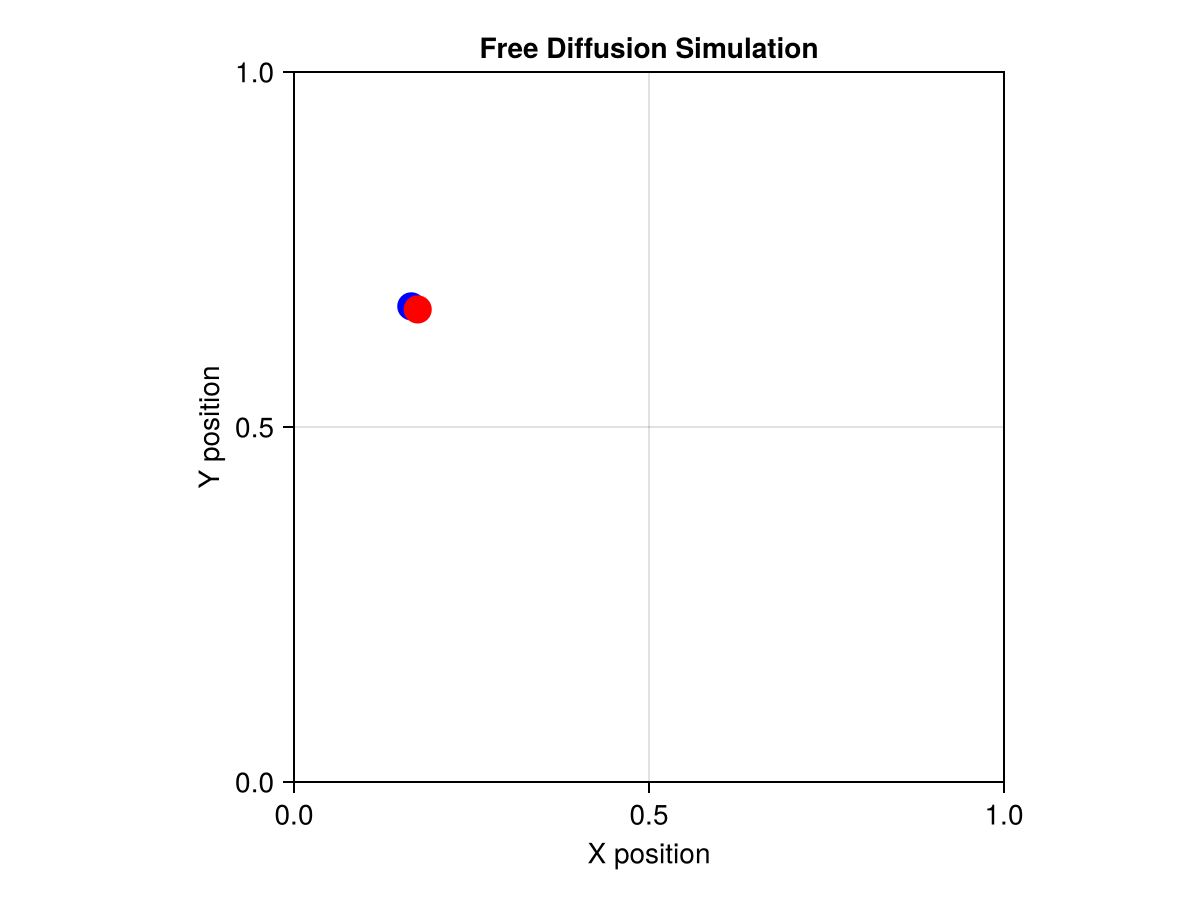

Animation saved as 'part6.mp4'


([0.16521878286414152 0.16740433432882812 … 0.2968817683441456 0.3139773015406272; 0.6699327198213385 0.6578509718740067 … 0.6527043955619726 0.6311908018383963], [0.17421752799738047 0.16785324465267448 … 0.09320975754709142 0.10602505691824961; 0.6655712308523042 0.6672260196563718 … 0.4083454604881304 0.41819631116048167])

In [ ]:
steps =round(Int, abs((transitions[6][1]/2) -transitions[5][1]))
positions = ([p1_path_5[1,end],p1_path_5[2,end]],[p2_path_5[1,end],p2_path_5[2,end]])
p1_path_6, p2_path_6 = simulate_diffusion(initial_positions=positions,steps = steps, animate= true,filename = "part6.mp4",box = 1.0,dt = 0.016)

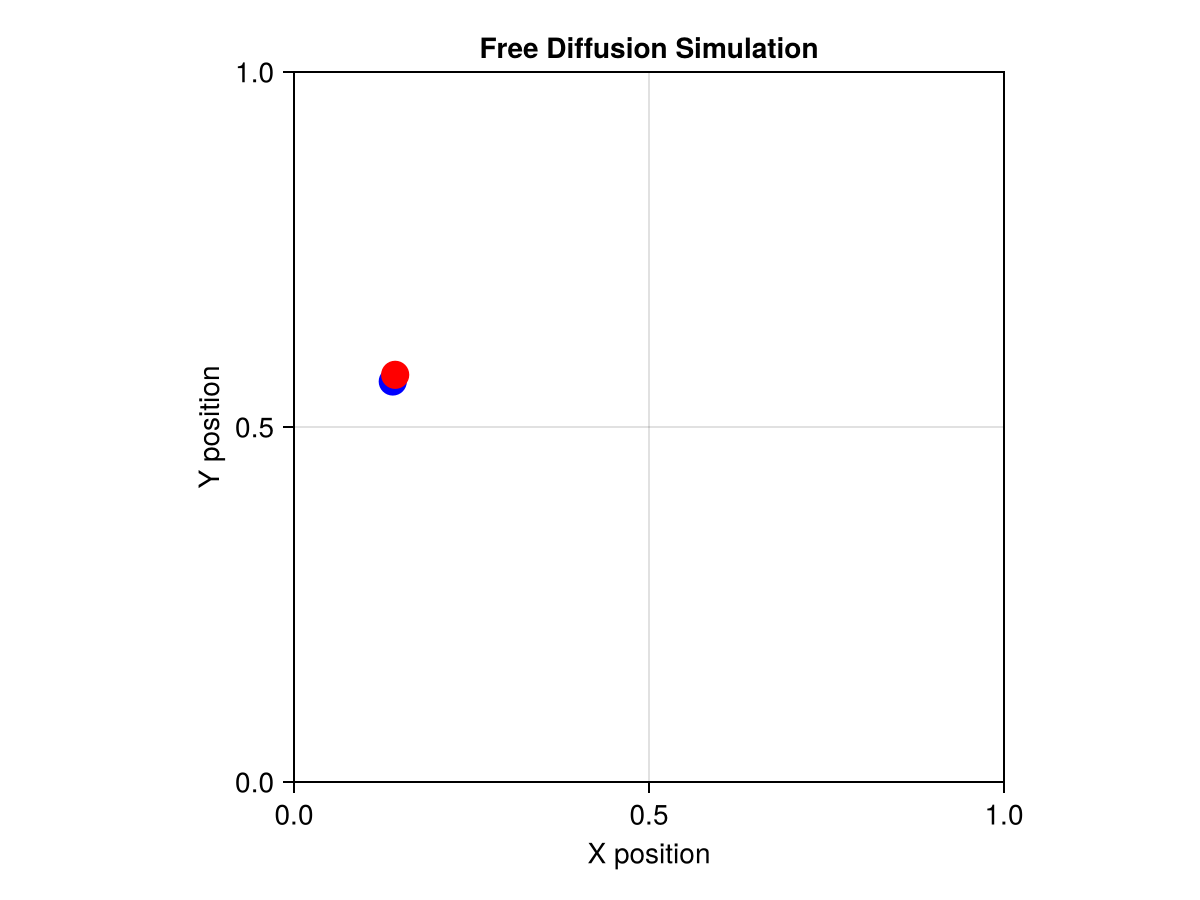

Animation saved as '0-18.mp4'


2×27 Matrix{Float64}:
 0.851592  0.852859  0.850239  0.854002  …  0.836264  0.807873  0.806848
 0.725619  0.71832   0.701158  0.704435     0.766102  0.763737  0.746622

In [50]:
steps =round(Int, abs((transitions[3][1]/2) -transitions[2][1]))
positions = ([p1_path_5[1,1],p1_path_5[2,1]],[p2_path_5[1,1],p2_path_5[2,1]])
p1_path_4, p2_path_4 = simulate_diffusion(initial_positions=positions,steps = steps, animate= true,filename = "0-18.mp4",box = 1.0,dt = 0.016)
p1_path_reversed_4 = reverse_columns_preserve_size(p1_path_1)
p2_path_reversed_4 = reverse_columns_preserve_size(p2_path_1)

shift the part 2 connection to the right

In [59]:
shift_x = -p1_path_4[1,1] + p1_path_3[1,end]
shift_y = -p1_path_4[2,1] + p1_path_3[2,end]
println("shift_x: ", shift_x)
println("shift_y: ", shift_y)

shift_x: 0.5782919666543687
shift_y: 0.27540384055639666


In [55]:
function shift(vec, shift_x, shift_y)
    return vec .+ [shift_x, shift_y]
end

shift (generic function with 1 method)

In [64]:
p_shift=shift(p1_path_4, shift_x, shift_y)

2×20 Matrix{Float64}:
 0.717397  0.722903  0.702154  0.693921  …  0.681483  0.66173   0.66178
 0.839486  0.848061  0.846393  0.831712     0.74619   0.779701  0.773458

In [65]:
println("p1_path_4: ", p_shift[1,1], ", ", p_shift[2,1])
println("p1_path_3: ", p1_path_3[1,end], ", ", p1_path_3[2,end])

p1_path_4: 0.7173966102842223, 0.8394861667794588
p1_path_3: 0.7173966102842223, 0.8394861667794588
